In [ ]:
from skimage.io import imread
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import cv2
from torchvision import transforms
from typing import List, Union


In [ ]:
# TODO: change these
RCNN_PATH = "rcnn.pt"
MODEL_PATH = "over-under-sampled-224.pth"

In [14]:
mapping = {0: "t1", 1: "tPN", 2: "tPNf", 3: "t2", 4: "t3", 5: "t4", 6: "t5", 7: "t6",
    8: "t7",
    9: "t8",
    10: "tM",
    11: "tB",
    12: "tEB",
    13: "tEmpty"
}

NCLASS = len(mapping)
SIZE = (224, 224)

def load_faster_RCNN_model_device(RCNN_PATH, use_GPU=True):
    if use_GPU:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    else:
        device = torch.device('cpu')
        
    model = torch.load(RCNN_PATH, map_location=device)
    return model,device

def extract_emb_frame_2d(embframe, model, device):# what is return type of this function? 
    return ExtractEmbFrame(embframe, embframe, embframe, model, device)[0]

def ExtractEmbFrame(r_channel, g_channel, b_channel, model, device):
    
    r_rgb = cv2.cvtColor(r_channel, cv2.COLOR_GRAY2RGB)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    image_tensor = transform(r_rgb).unsqueeze(0).to(device)
    with torch.no_grad():
        predictions = model(image_tensor)

    best_bbox = None
    best_score = 0
    for bbox, score in zip(predictions[0]['boxes'], predictions[0]['scores']):
        if score > best_score:
            best_bbox = bbox
            best_score = score

    if best_bbox is None:
        
        padded_r = np.zeros((800, 800), dtype=np.uint8) # update the size
        padded_g = padded_r
        padded_b = padded_r
        
        return padded_r, padded_g, padded_b

    else:
        
        best_bbox = best_bbox.cpu().numpy()

        x_min, y_min, x_max, y_max = best_bbox.astype(int)
        cropped_r = r_channel[y_min:y_max, x_min:x_max]
        cropped_g = g_channel[y_min:y_max, x_min:x_max]
        cropped_b = b_channel[y_min:y_max, x_min:x_max]

        h, w = cropped_r.shape
    
        if h > w:
            pad_left = (h - w) // 2
            pad_right = h - w - pad_left
            pad_top = pad_bottom = 0
        else:
            pad_top = (w - h) // 2
            pad_bottom = w - h - pad_top
            pad_left = pad_right = 0
    
        padded_r = cv2.copyMakeBorder(
            cropped_r,
            pad_top, pad_bottom, pad_left, pad_right,
            cv2.BORDER_CONSTANT,
            value=0  
        )
        padded_g = cv2.copyMakeBorder(
            cropped_g,
            pad_top, pad_bottom, pad_left, pad_right,
            cv2.BORDER_CONSTANT,
            value=0  
        )
        padded_b = cv2.copyMakeBorder(
            cropped_b,
            pad_top, pad_bottom, pad_left, pad_right,
            cv2.BORDER_CONSTANT,
            value=0  
        )

        return padded_r, padded_g, padded_b

class BiggerNet3D224(nn.Module):
    def __init__(self, num_classes=10):  # You can specify the number of classes here
        super(BiggerNet3D224, self).__init__()
        # Define the first convolutional layer: 3 input channels, 8 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(3, 8, 5)
        # Define the second convolutional layer: 8 input channels, 32 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(8, 32, 5)
        # Define the third convolutional layer: 32 input channels, 64 output channels, 3x3 kernel
        self.conv3 = nn.Conv2d(32, 64, 3)
        # Define a max pooling layer with 2x2 kernel
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers with updated sizes based on input image size (3x224x224)
        # After three convolutional layers and pooling, the image size will be reduced to 25x25
        self.fc1 = nn.Linear(64 * 25 * 25, 256)  # Updated to 64 * 25 * 25 to match new conv output
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Apply the first convolution, ReLU, and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply the second convolution, ReLU, and max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Apply the third convolution, ReLU, and max pooling
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten the tensor for the fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        # Apply fully connected layers with ReLU activations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Output layer (no activation function here because we'll use CrossEntropyLoss, which includes softmax)
        x = self.fc3(x)
        return x

def load_model(model_path, device, num_classes, model_class=BiggerNet3D224):
    """
    Load a model from a saved checkpoint.

    Parameters:
    - model_path: The path to the checkpoint file.
    - device: The device to load the model onto (e.g., 'cpu' or 'cuda').
    - num_classes: The number of classes in the dataset.
    - model_class: The class of the model to instantiate (use BiggerNet3D, above).

    Returns:
    - model: The loaded model with the state dictionary applied.
    - epoch: The epoch at which the checkpoint was saved.
    - best_val_auc: The best validation AUC at the time the checkpoint was saved.
    """
    # Load the checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    
    # Instantiate the model
    model = model_class(num_classes=num_classes).to(device)
    
    # Load the state dictionary into the model
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Retrieve additional information
    epoch = checkpoint['epoch']
    best_val_auc = checkpoint['best_val_auc']
    
    print(f"Model loaded from epoch {epoch} with best validation AUC: {best_val_auc:.4f}")
    
    return model, epoch, best_val_auc

def inference(model, device, depths_ims: Union[List[np.ndarray], torch.Tensor, np.ndarray], 
              map_output=True, output_to_str=False, totensor=True, resize=True, normalize=True, get_bbox=True, 
              rcnn_model=None, size=(224, 224)):
    """
    Perform inference on an image using a PyTorch model.

    Parameters:
    - model: The PyTorch model to use for inference.
    - device: The device to perform inference on (e.g., 'cpu' or 'cuda').
    - image: List of F-15, F0, and F15 focal depth images as uint8 np arrays or a PyTorch Tensor or a r x c x 3 numpy array. Must be a list if bboxes
                are to be extracted.   
    - map_output: Whether to map the output to a class label. Default is True.
    - output_to_str: Whether to convert the output to a string using mapping dict. Default is False
    - totensor: Whether to convert the image to a PyTorch tensor. 
    - resize: Whether to resize the image to the model's input size.
    - normalize: Whether to normalize the image.
    - get_bbox: Whether to return the bounding box. Image should be an uint8 numpy array in this case and resize should be True.
    - rcnn_model: The Faster R-CNN model to use for object detection. Required if get_bbox is True.
    - size: The size to resize the image to.

    Returns:
    - output: The model's output. Tensor if map_output is False, int if map_output is True, class name as a string if output_to_str.
    """
    assert (len(depths_ims) == 3 or (isinstance(depths_ims, np.ndarray) and depths_ims.shape[-1] == 3)), "depths_ims must contain three images."
    
    if get_bbox:
        assert rcnn_model is not None, "rcnn_model must be provided if get_bbox is True."
        assert totensor, "Image must be converted to a tensor if get_bbox is True."
        assert resize, "Image must be resized if get_bbox is True."
        depths_ims= [extract_emb_frame_2d(depths_ims[i], rcnn_model, device) for i in range(3)]
    
    if isinstance(depths_ims, list):
        image = np.stack(depths_ims, axis=-1)
    else:
        image = depths_ims
    
    if totensor:
        image = torch.from_numpy(image).float()
        image = image.permute(2, 0, 1)
    if resize:
        image = transforms.Resize((224, 224))(image)
    if normalize:
        image = image.float() / 255
    
    # Add a batch dimension
    image = image.unsqueeze(0).to(device)
    
    # Perform inference
    model.eval()
    with torch.no_grad():
        output = model(image)
    
    if map_output or output_to_str:
        output = torch.argmax(output, dim=1).item()
        if output_to_str:
            output = mapping[output]

    return output

def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [15]:
rcnn_model, rcnn_device = load_faster_RCNN_model_device(RCNN_PATH)
model, epoch, best_val_auc = load_model(MODEL_PATH, get_device(), NCLASS)
#depth_ims = imread(DATA_DIR  / "t-M-test.jpeg")
depth_im_paths = glob.glob(str(DATA_DIR / "test-*.jpeg"))

/var/folders/zw/x039kr6x13v1d173wnlv4fv80000gn/T/ipykernel_31351/4191902413.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(RCNN_PATH, map_location=d

Model loaded from epoch 49 with best validation AUC: 0.9944


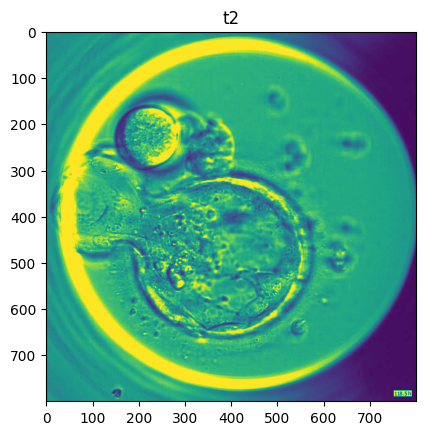

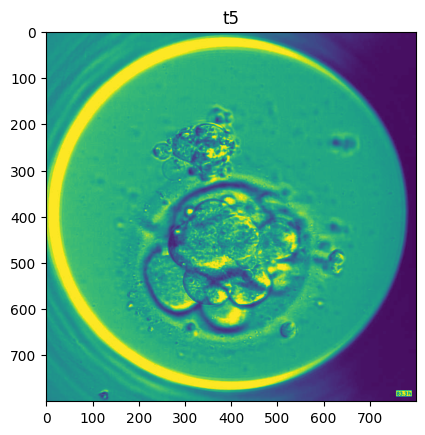

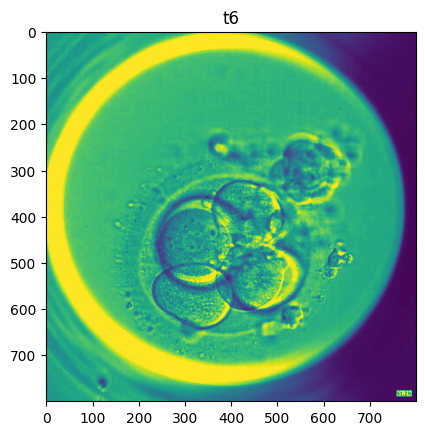

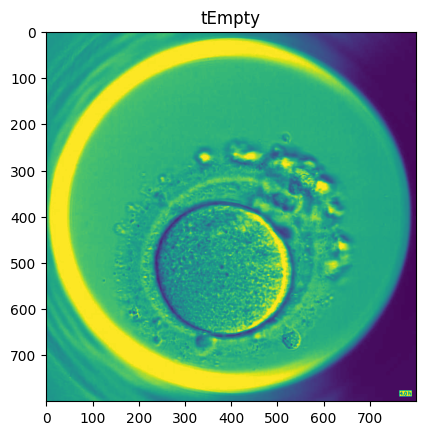

In [16]:
for depth_im_path in depth_im_paths:
    depth_im = imread(depth_im_path)
    plt.imshow(depth_im)
    depth_ims = [depth_im, depth_im, depth_im]
    label = inference(model, rcnn_device, depth_ims, map_output=True, output_to_str=True, totensor=True, resize=True, normalize=True, get_bbox=True, rcnn_model=rcnn_model)
    plt.title(label)
    plt.show()